<h1>Parte 2: Aprendizado Profundo na Prática</h1>

Os capítulos 5 a 9 ajudarão você a obter intuição prática sobre como resolver problemas do mundo real usando aprendizado profundo e irão familiarizá-lo com as essenciais práticas recomendadas de deep learning. 

<h1>Capítulo 05: Aprendizado profundo para visão computacional</h1>

Este capítulo cobre
- Compreender redes neurais convolucionais (convnets)
- Usar o aumento de dados para reduzir o overfitting
- Usar uma convnet pré-treinada para fazer a extração de características
- Afinar uma convnet pré-treinada
- Visualizar o que as convnets aprendem e como elas tomam decisões de classificação

Este capítulo apresenta redes neurais convolucionais, também conhecidas como "convnets", um tipo de modelo de aprendizagem profunda usado quase universalmente em aplicações de visão computacional. Você aprenderá a aplicar as convnets a problemas de classificação de imagens, em particular aqueles que envolvem conjuntos de dados de treinamento pequenos, que são o caso de uso mais comum, caso você não seja uma grande empresa de tecnologia.

Obs: As bibliotecas tensorflow e pytorch são mantidas pelos maiores laboratórios de pesquisa de IA do mundo. Google Brain com tensorflow (keras) e Facebook IA Research (FAIR) com o pytorch.
Usaremos o keras do tensorflow.

<h1>5.1 Introdução a convnets</h1>

Estamos prestes a mergulhar na teoria do que são as convnets e por que elas têm tanto sucesso em tarefas de visão computacional. Mas primeiro, vamos dar uma olhada prática em um exemplo simples de convnet. Ele usa uma convnet para classificar os dígitos MNIST, uma tarefa que realizamos no capítulo 2 usando uma rede densamente conectada (nossa precisão de teste era de  ~98%). Apesar de a convnet ser básica, sua precisão será melhor do que o modelo densamente conectado do capítulo 2. Obs: uma rede densamente conectada (MLP) pode ser implementada pelas bibliotecas sklearn e keras.

As linhas de código a seguir mostram a aparência de uma convnet básica. É uma pilha de camadas Conv2D e MaxPooling2D. Você verá em um minuto exatamente o que eles fazem.


In [8]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Importante, uma convnet toma como entrada tensores da forma (image_height, image_width, image_channels) 
(não incluindo a dimensão do lote). Nesse caso, vamos configurar a convnet para processar entradas de tamanho (28, 28, 1), que é o formato das imagens MNIST. Faremos isso passando o argumento input_shape = (28, 28, 1) para a primeira camada.

Vamos exibir a arquitetura da convnet até agora:

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


Você pode ver que a saída de cada camada Conv2D e MaxPooling2D é um tensor 3D da forma (altura, largura, canais). As dimensões de largura e altura tendem a encolher à medida que você se aprofunda na rede. O número de canais é controlado pelo primeiro argumento passado para as camadas Conv2D (32 ou 64).

O próximo passo é alimentar o último tensor de saída (da forma (3, 3, 64)) em uma rede de classificadores densamente conectada, como aqueles com os quais você já está familiarizado: uma pilha de camadas Densas. Esses classificadores processam vetores, que são 1D, enquanto a saída corrente é um tensor 3D. Primeiro temos que achatar as saídas 3D para 1D e, em seguida, adicionar algumas camadas densas.

In [10]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Faremos uma classificação de 10 direções, usando uma camada final com 10 saídas e uma ativação softmax. Veja como a rede se parece agora:

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

Como você pode ver, as saídas (3, 3, 64) são achatadas em vetores de forma (576), antes de passar por duas camadas Densas.
Agora, vamos treinar a convnet nos dígitos MNIST. Reutilizaremos muito do código do exemplo MNIST no capítulo 2. 
(pré-processaremos os dados reformulando-os de acordo com o formato esperado pela rede e dimensionando-os para que todos os valores fiquem no intervalo [0, 1]. Anteriormente, nossas imagens de treinamento, por exemplo, eram armazenadas em uma matriz de forma (60000, 28, 28) do tipo uint8 com valores no intervalo [0, 255]. Nós o transformamos em uma matriz float32 (60000, 28, 28, 1) com valores entre 0 e 1.

In [12]:
from keras.datasets import mnist
from keras.utils import to_categorical
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print (train_images.shape)
print (test_images.shape)
print (len(train_labels))
print (len(test_labels))
print (train_labels)
print (test_labels)

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print (train_images.shape)
print (test_images.shape)
print (len(train_labels))
print (len(test_labels))
print (train_labels)
print (test_labels)

(60000, 28, 28)
(10000, 28, 28)
60000
10000
[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]
(60000, 28, 28, 1)
(10000, 28, 28, 1)
60000
10000
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 2176s 36ms/step - loss: 0.4482 - acc: 0.8909
Epoch 2/5
60000/60000 [==============================] - 2502s 42ms/step - loss: 0.4985 - acc: 0.9292
Epoch 3/5
60000/60000 [==============================] - 4727s 79ms/step - loss: 0.8183 - acc: 0.9323
Epoch 4/5
60000/60000 [==============================] - 10704s 178ms/step - loss: 1.2259 - acc: 0.9187
Epoch 5/5
60000/60000 [==============================] - 2055s 34ms/step - loss: 1.5243 - acc: 0.9032


Let’s evaluate the model on the test data:

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Enquanto a rede densamente conectada do capítulo 2 teve uma precisão de teste de ~98%, a convnet básica tem uma precisão de teste de 99,3%: diminuímos a taxa de erro em 68%
(relativo). Não é ruim! (o resultado da minha simulação está diferente do livro)

Mas por que esta convnet simples funciona tão bem, em comparação com um modelo densamente conectado? Para responder a isso, vamos nos aprofundar no que as camadas Conv2D e MaxPooling2D fazem.

<h1>5.1.1 A operação de convolução</h1>

A diferença fundamental entre uma camada densamente conectada e uma camada de convolução é a seguinte: camadas densas aprendem padrões globais em seu espaço de caracterísitcas de entrada (por exemplo, para um dígito MNIST, padrões envolvendo todos os pixels), enquanto camadas de convolução aprendem padrões locais (consulte a figura 5.1). ): no caso de imagens, padrões encontrados em pequenas janelas 2D das entradas. No exemplo anterior, essas janelas eram todas 3 × 3 (window_height, window_width).

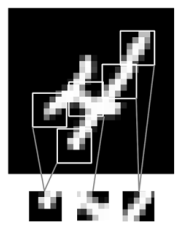
Figura 5.1: Imagens podem ser quebradas em padrões locais, como bordas, texturas e assim por diante.

Esta característica chave dá às duas propriedades interessantes:
- Os padrões que eles aprendem são invariantes à translação. Depois de aprender um certo padrão no canto inferior direito de uma imagem, um convnet pode reconhecê-lo em qualquer lugar: por exemplo, no canto superior esquerdo. Uma rede densamente conectada teria que aprender o padrão novamente se aparecesse em um novo local. Isso torna os dados de convnets eficientes ao processar imagens (porque o mundo visual é fundamentalmente invariante à translação): eles precisam de menos amostras de treinamento para aprender representações que tenham poder de generalização.
- Eles podem aprender hierarquias espaciais de padrões (veja a figura 5.2). Uma primeira camada de convolução aprende pequenos padrões locais, como bordas, uma segunda camada de convolução aprende padrões maiores feitos das características das primeiras camadas e assim por diante. Isso permite que os convnets aprendam eficientemente conceitos visuais cada vez mais complexos e abstratos (porque o mundo visual é fundamentalmente espacialmente hierárquico).

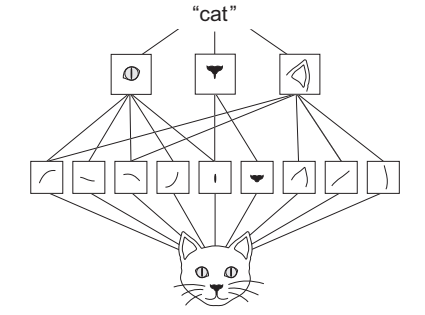
Figura 5.2: O mundo visual forma uma hierarquia espacial de módulos visuais: bordas hiperlocais se combinam em objetos locais, como olhos ou ouvidos, que se combinam em conceitos de alto nível, como "gato".

Convoluções operam sobre tensores 3D, chamados de mapas de características, com dois eixos espaciais (altura e largura), bem como um eixo de profundidade (também chamado de eixo dos canais). Para uma imagem RGB, a dimensão do eixo de profundidade é 3, porque a imagem tem três canais de cores: vermelho, verde e azul. Para uma imagem em preto e branco, como os dígitos MNIST, a profundidade é 1 (níveis de cinza). A operação de convolução extrai os patches (tamanho do filtro) de seu mapa de características de entrada e aplica a mesma transformação a todos esses patches, produzindo um mapa de características de saída. Esse mapa de características de saída ainda é um tensor 3D: tem largura e altura. Sua profundidade pode ser arbitrária, porque a profundidade de saída é um parâmetro da camada, e os diferentes canais nesse eixo de profundidade não mais representam cores específicas como na entrada RGB; em vez disso, eles representam filtros. Os filtros codificam aspectos específicos dos dados de entrada: em um nível alto, um único filtro pode codificar o conceito “presença de uma face na entrada”, por exemplo.
No exemplo MNIST, a primeira camada de convolução tem como entrada um mapa de características de tamanho (28, 28, 1) e gera um mapa de características de tamanho (26, 26, 32): calcula 32 filtros em sua entrada (output_depth). Cada um desses 32 canais de saída contém uma grade de valores de 26 × 26, que é um mapa de resposta do filtro sobre a entrada, indicando a resposta desse padrão de filtro em diferentes locais na entrada (consulte a figura 5.3). Isso é o que o termo mapa de características significa: cada dimensão no eixo de profundidade é uma característica (ou filtro), e o tensor de saída 2D [:,:, n] é o mapa espacial 2D da resposta deste filtro sobre a entrada.

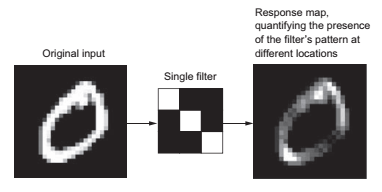
Figura 5.3: O conceito de mapa de resposta: um mapa 2D da presença de um padrão em diferentes locais em uma entrada

Convoluções são definidas por dois parâmetros principais:
- Tamanho dos patches extraídos das entradas - Estes são tipicamente 3 × 3 ou 5 × 5. No exemplo, eles eram 3 × 3, o que é uma escolha comum.
- Profundidade do mapa de recursos de saída - O número de filtros calculados pela convolução. O exemplo começou com uma profundidade de 32 e terminou com uma profundidade de 64.

Em camadas do Keras Conv2D, esses parâmetros são os primeiros argumentos passados para a camada: Conv2D (output_depth, (window_height, window_width)).
A convolução funciona deslizando essas janelas de tamanho 3 × 3 ou 5 × 5 pelo mapa de características de entrada 3D, parando em todos os locais possíveis e extraindo o patch 3D das características circundantes (shape (window_height, window_width, input_depth)). Cada um desses trechos 3D é então transformado (por meio de um produto tensorial com a mesma matriz de peso aprendida, chamada núcleo de convolução) em um vetor 1D de forma (output_depth,). Todos esses vetores são então reagrupados espacialmente em um mapa de saída 3D de forma (altura, largura, deflexão de saída). Cada localização espacial no mapa de características de saída corresponde ao mesmo local no mapa de características de entrada (por exemplo, o canto inferior direito da saída contém informações sobre o canto inferior direito da entrada). Por exemplo, com janelas 3 × 3, a saída vetorial [i, j,:] vem da entrada de correção 3D [i-1: i + 1, j-1: j + 1,:]. O processo completo está detalhado na figura 5.4.

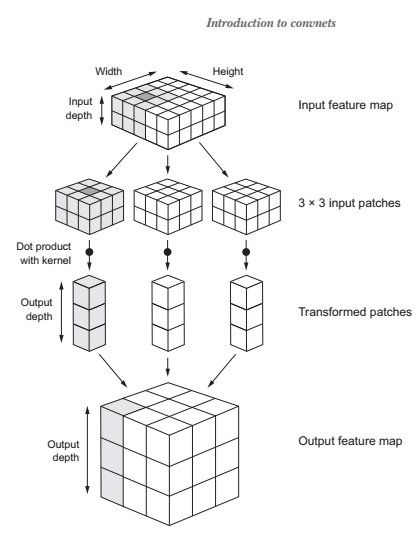
Figura 5.4: Como funciona a convolução

Observe que a largura e a altura da saída podem diferir da largura e da altura da entrada. Eles podem diferir por dois motivos:
- Efeitos de borda, que podem ser neutralizados pelo preenchimento do mapa de recursos de entrada
- O uso de passos, que eu vou definir em um segundo

Vamos dar uma olhada mais profunda nessas noções.

(ver restante no livro) 

<b>UNDERSTANDING BORDER EFFECTS AND PADDING</b>

<b>UNDERSTANDING CONVOLUTION STRIDES</b>

<h1>5.1.2 The max-pooling operation</h1>

<h1>5.2 Treinando uma convnet do zero em um pequeno conjunto de dados</h1>

Ter que treinar um modelo de classificação de imagem usando muito poucos dados é uma situação comum, que você provavelmente encontrará na prática se já fez a visão computacional em um contexto profissional. Um “poucas” amostras podem significar de algumas centenas a algumas dezenas de milhares de imagens. Como exemplo prático, nos concentraremos na classificação de imagens como cães ou gatos, em um conjunto de dados contendo 4.000 fotos de gatos e cães (2.000 gatos, 2.000 cachorros). Usaremos 2.000 fotos para treinamento - 1.000 para validação e 1.000 para testes.

Nesta seção, analisaremos uma estratégia básica para resolver esse problema: treinando um novo modelo a partir do zero usando os poucos dados que você tem. Você começará ingenuamente treinando uma pequena convnet nas 2.000 amostras de treinamento, sem nenhuma regularização, para definir uma linha de base para o que pode ser alcançado. Isso levará você a uma precisão de classificação de 71%. Nesse ponto, a questão principal será overfitting. Em seguida, apresentaremos o aumento de dados, uma técnica poderosa para reduzir o overfitting na visão computacional. Ao usar o aumento de dados, você aprimora a rede para alcançar uma precisão de 82%.

Na próxima seção, analisaremos mais duas técnicas essenciais para aplicar aprendizado profundo a conjuntos de dados pequenos: extração de recursos com uma rede pré-treinada (que atingirá uma precisão de 90% a 96%) e ajuste fino de uma rede pré-programada ( isto te levará a uma precisão final de 97%). Juntas, essas três estratégias - treinar um modelo pequeno do zero, fazer extração de recurso usando um modelo pré-treinado e ajustar um modelo pré-treinado - constituirão sua futura caixa de ferramentas para resolver o problema da classificação de imagens com pequenos conjuntos de dados.

<h1>5.2.1 A relevância da aprendizagem profunda para problemas com pequenos dados</h1>

Você vai ouvir que o aprendizado profundo só funciona quando há muitos dados disponíveis. Isso é válido em parte: uma característica fundamental da aprendizagem profunda é que ela pode encontrar recursos interessantes nos dados de treinamento por conta própria, sem necessidade de engenharia manual de recursos, e isso só pode ser alcançado quando há muitos exemplos de treinamento disponíveis. Isso é especialmente verdadeiro para problemas em que as amostras de entrada são muito highdimensionais, como imagens.

Mas o que constitui muitas amostras é relativo, em relação ao tamanho e à profundidade da rede que você está tentando treinar, para começar. Não é possível treinar um convnet para resolver problema complexo com apenas algumas dezenas de amostras, mas algumas centenas podem potencialmente bastar se o modelo for pequeno e bem regularizado e a tarefa for simples. Como as convnets aprendem recursos locais e invariantes à translação, elas são altamente eficientes em termos de dados em problemas de percepção. O treinamento de uma convnet a partir do zero em um conjunto de dados de imagem muito pequeno ainda renderá resultados razoáveis, apesar de uma relativa falta de dados, sem a necessidade de qualquer engenharia de características personalizada. Você verá isso em ação nesta seção.

Além disso, os modelos de aprendizagem profunda são altamente reutilizáveis por natureza: você pode usar, digamos, um modelo de classificação de imagem ou de fala para texto treinado em um conjunto de dados de grande escala e reutilizá-lo em um problema significativamente diferente com pequenas alterações. Especificamente, no caso da visão computacional, muitos modelos pré-treinados (geralmente treinados no conjunto de dados ImageNet) estão agora disponíveis publicamente para download e podem ser usados para inicializar modelos poderosos de visão com poucos dados. Isso é o que você fará na próxima seção. Vamos começar por colocar as mãos nos dados.

<h1>5.2.2 Fazendo o download dos dados</h1>
O conjunto de dados "Cães vs gatos" que você vai usar não é fornecido com o Keras. Ele foi disponibilizado pela Kaggle como parte de uma competição de visão computacional no final de 2013, quando os convnets não eram convencionais. Você pode fazer o download do conjunto de dados original em www.kaggle.com/c/dogs-vs-cats/data (você precisará criar uma conta do Kaggle se ainda não tiver uma - não se preocupe, o processo é indolor).

As imagens são JPEGs em cores de resolução média. A Figura 5.8 mostra alguns exemplos.

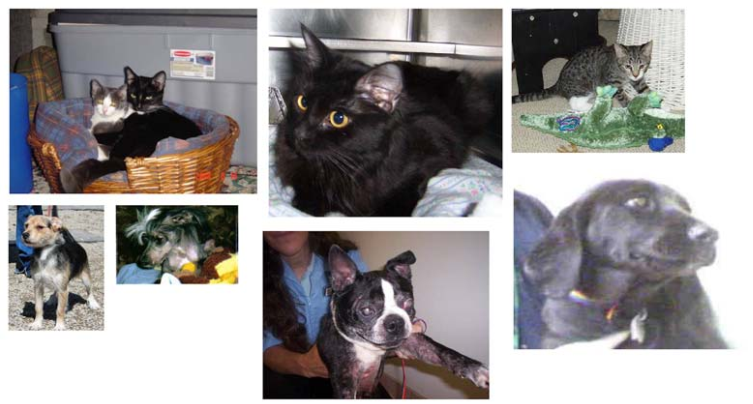
Figura 5.8: Amostras do conjunto de dados Dogs vs. Cats. Os tamanhos não foram modificados: as amostras são heterogêneas em tamanho, aparência e assim por diante.

Sem surpresa, a competição de cães vs gatos da Kaggle em 2013 foi vencida pelos participantes que usaram as convnets. As melhores entradas alcançaram até 95% de precisão. Neste exemplo, você chegará perto dessa precisão (na próxima seção), embora você treine seus modelos com menos de 10% dos dados disponíveis para os concorrentes.

Este conjunto de dados contém 25.000 imagens de cães e gatos (12.500 de cada classe) e é 543 MB (comprimido). Depois de fazer o download e descompactá-lo, você criará um novo conjunto de dados contendo três subconjuntos: um conjunto de treinamento com 1.000 amostras de cada classe, um conjunto de validação com 500 amostras de cada classe e um conjunto de teste com 500 amostras de cada classe.

A seguir está o código para fazer isso.

import os, shutil

# Cria diretórios
# Diretório onde você vai armazenar seu conjunto de dados menor D:\Tatiana\data sets
base_dir = 'D:\Tatiana\data sets\cats_and_dogs_small'
os.mkdir(base_dir)

# Diretórios para as divisões de treinamento, validação e teste
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Diretório com fotos de gatos para o treinamento
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Diretório com fotos de cachorro para o treinamento
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Diretório com fotos de gato para a validação
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Diretório com fotos de cachorro para a validação
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Diretório com fotos de gato para o teste
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Diretório com fotos do cão para o teste
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)


# Caminho para o diretório onde o conjunto de dados original foi descompactado
original_dataset_dir = 'D:\Tatiana\data sets\dogs-vs-cats'

# Copia as primeiras 1.000 imagens de gatos para train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copia as próximas 500 imagens de gatos para validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copia as próximas 500 imagens de gatos para test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copia as primeiras 1.000 imagens de cães para train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copia as próximas 500 imagens de cachorro para validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copia as próximas 500 imagens de cães para test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

Como verificação de integridade, vamos contar quantas fotos há em cada divisão de treinamento (treinamento/validação/teste):

In [17]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


#import os
#base_dir = 'D:\Tatiana\data sets\cats_and_dogs_small'
#train_dir = os.path.join(base_dir, 'train')
#validation_dir = os.path.join(base_dir, 'validation')
#test_dir = os.path.join(base_dir, 'test')

Então você realmente tem 2.000 imagens de treinamento, 1.000 imagens de validação e 1.000 imagens de teste. Cada divisão contém o mesmo número de amostras de cada classe: trata-se de um problema de classificação binária equilibrado, o que significa que a acurácia da classificação será uma medida apropriada de sucesso.

<h1>5.2.3 Construindo sua rede</h1>
    
Você construiu uma pequena convnet para o MNIST no exemplo anterior, portanto você deve estar familiarizado com essas convnets. Você reutilizará a mesma estrutura geral: a convnet será uma pilha de camadas Conv2D (com ativação relu) e MaxPooling2D alternadas.

Mas como você está lidando com imagens maiores e com um problema mais complexo, sua rede ficará maior, de acordo: ela terá mais um estágio Conv2D + MaxPooling2D. Isso serve tanto para aumentar a capacidade da rede quanto para reduzir ainda mais o tamanho dos mapas de características, para que eles não sejam muito grandes quando você alcança a camada Flatten. Aqui, porque você começa a partir de entradas de tamanho 150 × 150 (uma escolha um pouco arbitrária), você acaba com mapas de características de tamanho 7 × 7 antes da camada Flatten.

OBSERVAÇÃO A profundidade dos mapas de características aumenta progressivamente na rede (de 32 para 128), enquanto o 
tamanho dos mapas de características diminui (de 148 × 148 para 7 × 7). Este é um padrão que você verá em quase todas as      convnets.
    
Como você está atacando um problema de classificação binária, você terminará a rede com uma única unidade (uma camada Densa de tamanho 1) e uma ativação sigmóide. Esta unidade codificará a probabilidade de que a rede esteja olhando para uma classe ou outra.


In [20]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Vejamos como as dimensões dos mapas de características mudam a cada camada sucessiva:

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 128)       147584    
__________

Para a etapa de compilação, você seguirá com o otimizador do RMSprop, como de costume. Como você encerrou a rede com uma única unidade sigmóide, você usará crossentropy binária como a perda (como lembrete, confira a tabela 4.1 - Escolhendo a função correta de ativação e perda da última camada para o seu modelo - para uma planilha sobre qual função de perda usar em várias situações).

In [22]:
from keras import optimizers
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

<h1>5.2.4 Pré-processamento de dados</h1>
Como você já deve saber, os dados devem ser formatados em tensores de ponto flutuante pré-processados apropriadamente antes de serem alimentados na rede. Atualmente, os dados ficam em uma unidade como arquivos JPEG, portanto, as etapas para inseri-los na rede são aproximadamente os seguintes:

1 Leia os arquivos de imagem.

2 Decodifique o conteúdo JPEG para matrizes RGB de pixels.

3 Converta-os em tensores de ponto flutuante.

4 Redimensione os valores de pixel (entre 0 e 255) para o intervalo [0, 1] (como você sabe, as redes neurais preferem lidar com pequenos valores de entrada).

Pode parecer um pouco assustador, mas felizmente Keras tem utilitários para cuidar desses passos automaticamente. Keras tem um módulo com ferramentas auxiliares de processamento de imagem, localizado em keras.preprocessing.image. Em particular, ele contém a classe ImageDataGenerator, que permite configurar rapidamente geradores Python que podem transformar automaticamente arquivos de imagem em disco em lotes de tensores pré-processados. Isso é o que você vai usar aqui.

In [30]:
from keras.preprocessing.image import ImageDataGenerator

# Re escala todas as imagens em 1/255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# nome do diretório, Redimensiona todas as imagens para 150 × 150, Como você usa a perda binary_crossentropy, 
# você precisa de rótulos binários.
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Vejamos a saída de um desses geradores: ele gera lotes de imagens RGB de 150 × 150 (shape (20, 150, 150, 3)) e rótulos binários (shape (20,)). Existem 20 amostras em cada lote (o tamanho do lote). Observe que o gerador gera esses lotes indefinidamente: faz um loop indefinidamente sobre as imagens na pasta de rótulos. Por esta razão, você precisa
parar o loop de iteração em algum momento:

In [24]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Vamos ajustar o modelo aos dados usando o gerador. Você faz isso usando o método fit_generator, o equivalente de ajuste para geradores de dados como este. Ele espera, como seu primeiro argumento, um gerador Python que produzirá lotes de entradas e rótulos indefinidamente, como este. Como os dados estão sendo gerados indefinidamente, o modelo Keras precisa saber quantas amostras extrair do gerador antes de declarar uma época. Este é o papel do argumento steps_per_epoch: depois de ter desenhado os lotes steps_per_epoch do gerador - isto é, depois de ter corrido para steps_per_epoch gradiente descida - o processo de ajuste irá para a próxima época. Nesse caso, os lotes são 20 amostras, portanto, serão necessários 100 lotes até você ver sua meta de 2.000 amostras.

Ao usar fit_generator, você pode passar um argumento validation_data. É importante observar que esse argumento pode ser um gerador de dados, mas também pode ser uma tupla de matrizes Numpy. Se você passar um gerador como validation_data, espera-se que este gerador produza lotes de dados de validação indefinidamente; Portanto, você também deve especificar o argumento validation_steps, que informa ao processo quantos lotes serão extraídos do gerador de validação para avaliação.

In [25]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 157s 2s/step - loss: 0.6872 - acc: 0.5370 - val_loss: 0.6659 - val_acc: 0.6250
Epoch 2/30
100/100 [==============================] - 161s 2s/step - loss: 0.6509 - acc: 0.6250 - val_loss: 0.6357 - val_acc: 0.6180
Epoch 3/30
100/100 [==============================] - 159s 2s/step - loss: 0.6021 - acc: 0.6835 - val_loss: 0.5992 - val_acc: 0.6680
Epoch 4/30
100/100 [==============================] - 161s 2s/step - loss: 0.5668 - acc: 0.7005 - val_loss: 0.5801 - val_acc: 0.6870
Epoch 5/30
100/100 [==============================] - 161s 2s/step - loss: 0.5406 - acc: 0.7190 - val_loss: 0.5577 - val_acc: 0.7140
Epoch 6/30
100/100 [==============================] - 159s 2s/step - loss: 0.5121 - acc: 0.7445 - val_loss: 0.5598 - val_acc: 0.7130
Epoch 7/30
100/100 [==============================] - 159s 2s/step - loss: 0.4846 - acc: 0.7555 - val_loss: 0.5654 - val_acc: 0.7020
Epoch 8/30
100/100 [==============================] - 158s 2s/step - 

É uma boa prática guardar sempre os seus modelos após o treino

In [26]:
model.save('cats_and_dogs_small_1.h5')

Vamos traçar a perda e acurácia do modelo sobre os dados de treinamento e validação durante o treinamento (ver figuras 5.9 e 5.10).

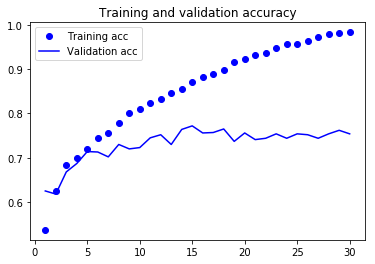

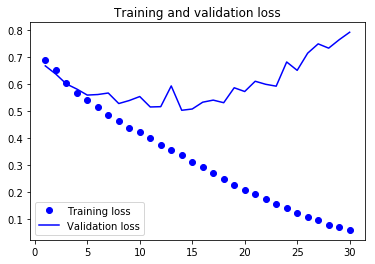

In [28]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

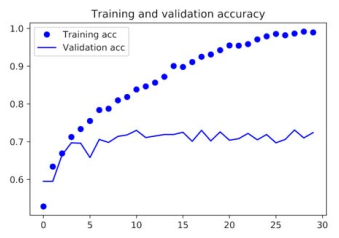
Figura 5.9: Acurácia de treinamento e validação

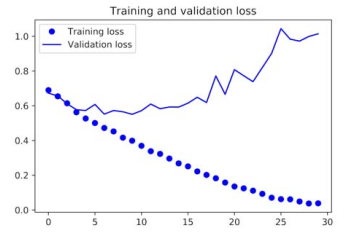
Figura 5.10: Perda de treinamento e validação

Esses plotes são características de overfitting. A acurácia do treinamento aumenta linearmente ao longo do tempo, até atingir quase 100%, enquanto a acurácia de validação diminui em 70-72%. A perda de validação atinge seu mínimo depois de apenas cinco épocas e depois aumenta, enquanto a perda de treinamento continua diminuindo linearmente até atingir quase 0.

Como você tem relativamente poucas amostras de treinamento (2.000), o overfitting será sua preocupação número um. Você já sabe sobre diversas técnicas que podem ajudar a atenuar o overfitting, como dropout e a regularização de L2. Agora vamos trabalhar com um novo, específico para visão computacional e usado quase que universalmente ao processar imagens com modelos de aprendizagem profunda: aumento de dados.

<h1>5.2.4 Usando o aumento de dados</h1>
O overfitting é causado por ter muito poucas amostras para aprender, tornando-o incapaz de treinar um modelo que possa generalizar novos dados. Dados infinitos dados, seu modelo seria exposto a todos os aspectos possíveis da distribuição de dados em mãos. O aumento de dados utiliza a abordagem de gerar mais dados de treinamento a partir de amostras de treinamento existentes, aumentando as amostras por meio de várias transformações aleatórias que geram imagens de aparência confiável. O objetivo é que, no tempo de treinamento, seu modelo nunca verá exatamente a mesma imagem duas vezes. Isso ajuda a expor o modelo a mais aspectos dos dados e a generalizar melhor.

Em Keras, isso pode ser feito configurando um número de transformações aleatórias a serem executadas nas imagens lidas pela instância ImageDataGenerator. Vamos começar com um exemplo.

In [31]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

Estas são apenas algumas das opções disponíveis (para mais, veja a documentação do Keras).
Vamos rapidamente passar por cima deste código:
- rotation_range é um valor em graus (0-180), um intervalo dentro do qual é possível girar imagens aleatoriamente.
- width_shift e height_shift são intervalos (como uma fração da largura total ou altura) para a conversão aleatória de imagens na vertical ou na horizontal.
- shear_range é para aplicar aleatoriamente transformações de cisalhamento.
- zoom_range é para zoom aleatoriamente dentro de fotos.
- horizontal_flip é para virar aleatoriamente metade das imagens horizontalmente - relevante quando não há suposições de assimetria horizontal (por exemplo, imagens do mundo real).
- fill_mode é a estratégia usada para preencher pixels recém-criados, que podem aparecer após uma rotação ou uma alteração de largura / altura.

Vamos ver as imagens aumentadas (veja a figura 5.11).

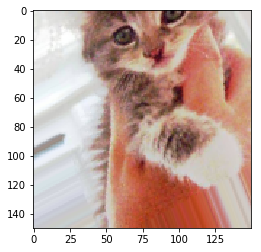

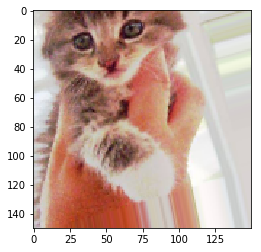

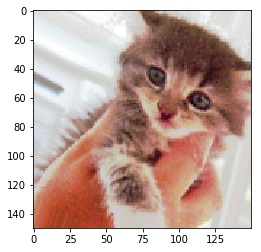

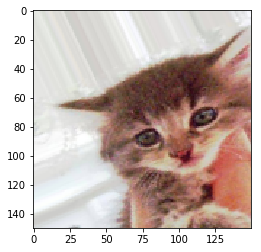

In [35]:
# Módulo com utilitários de pré-processamento de imagem
from keras.preprocessing import image
fnames = [os.path.join(train_cats_dir, fname) for
    fname in os.listdir(train_cats_dir)]
# Escolhe uma imagem para aumentar
img_path = fnames[3]
# Lê a imagem e redimensiona
img = image.load_img(img_path, target_size=(150, 150))
# Converte-o em um array Numpy com forma (150, 150, 3)
x = image.img_to_array(img)
# Remodela-o para (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)
# Gera lotes de imagens transformadas aleatoriamente. Loops indefinidamente, 
# então você precisa quebrar o loop em algum momento!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

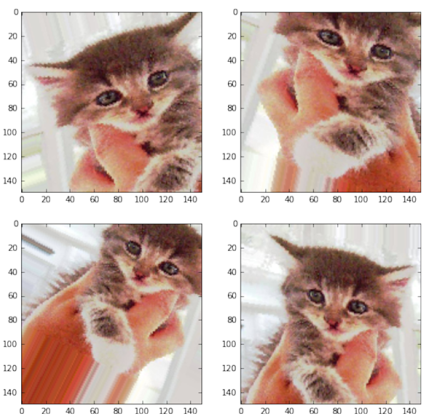]
Figura 5.11: Geração de fotos de gatos via aumento aleatório de dados.

Se você treinar uma nova rede usando essa configuração de aumento de dados, a rede nunca verá a mesma entrada duas vezes. Mas as entradas que ele vê ainda estão pesadamente inter-relacionadas, porque elas vêm de um pequeno número de imagens originais - você não pode produzir novas informações, só pode remixar informações existentes. Como tal, isso pode não ser suficiente para se livrar completamente do overfitting. Para combater ainda mais o overfitting, você também adicionará uma camada de dropout ao seu modelo, logo antes do classificador densamente conectado.

In [36]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

Vamos treinar a rede usando aumento de dados e dropout.

In [37]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Observe que os dados de validação não devem ser aumentados!
test_datagen = ImageDataGenerator(rescale=1./255)

# Diretório de rótulos, Redimensiona todas as imagens para 150 × 150, 
# Porque você usa binary_crossentropy perda, você precisa de rótulos binárias.
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 245s 2s/step - loss: 0.6935 - acc: 0.5184 - val_loss: 0.6863 - val_acc: 0.4918
Epoch 2/100
100/100 [==============================] - 245s 2s/step - loss: 0.6825 - acc: 0.5613 - val_loss: 0.6794 - val_acc: 0.5367
Epoch 3/100
100/100 [==============================] - 246s 2s/step - loss: 0.6729 - acc: 0.5753 - val_loss: 0.6608 - val_acc: 0.5857
Epoch 4/100
100/100 [==============================] - 243s 2s/step - loss: 0.6556 - acc: 0.6059 - val_loss: 0.6250 - val_acc: 0.6418
Epoch 5/100
100/100 [==============================] - 242s 2s/step - loss: 0.6488 - acc: 0.6172 - val_loss: 0.7254 - val_acc: 0.5476
Epoch 6/100
100/100 [==============================] - 244s 2s/step - loss: 0.6408 - acc: 0.6288 - val_loss: 0.6146 - val_acc: 0.6405
Epoch 7/100
100/100 [==============================] - 243s 2s/step - loss: 0.6269 - acc: 0.6459 - val_loss: 0.5

100/100 [==============================] - 245s 2s/step - loss: 0.4212 - acc: 0.7953 - val_loss: 0.4179 - val_acc: 0.8189
Epoch 62/100
100/100 [==============================] - 242s 2s/step - loss: 0.4168 - acc: 0.8078 - val_loss: 0.4362 - val_acc: 0.8109
Epoch 63/100
100/100 [==============================] - 48275s 483s/step - loss: 0.4201 - acc: 0.8041 - val_loss: 0.4009 - val_acc: 0.8183
Epoch 64/100
100/100 [==============================] - 243s 2s/step - loss: 0.4177 - acc: 0.8069 - val_loss: 0.4447 - val_acc: 0.8003
Epoch 65/100
100/100 [==============================] - 245s 2s/step - loss: 0.4035 - acc: 0.8141 - val_loss: 0.4525 - val_acc: 0.8039
Epoch 66/100
100/100 [==============================] - 245s 2s/step - loss: 0.4069 - acc: 0.8156 - val_loss: 0.4705 - val_acc: 0.7899
Epoch 67/100
100/100 [==============================] - 243s 2s/step - loss: 0.3910 - acc: 0.8206 - val_loss: 0.4126 - val_acc: 0.8084
Epoch 68/100
100/100 [==============================] - 249s 2s/

Vamos salvar o modelo - você o usará na seção 5.4.

In [ ]:
model.save('cats_and_dogs_small_2.h5')

E vamos traçar os resultados novamente: veja as figuras 5.12 e 5.13. Graças ao aumento de dados e ao dropout, você não está mais com overfitting: as curvas de treinamento estão acompanhando de perto as curvas de validação. Agora você alcança uma acurácia de 82%, uma melhoria relativa de 15% em relação ao modelo não regularizado.

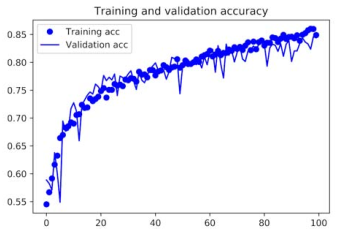
Figura 5.12: Acurácia de treinamento e validação com aumento de dados

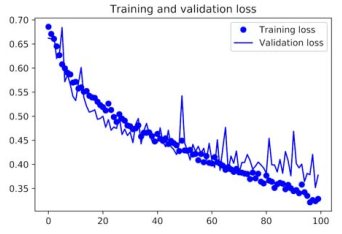
Figura 5.13: Perda de treinamento e validação com aumento de dados

Usando técnicas de regularização ainda mais e ajustando os parâmetros da rede (como o número de filtros por camada de convolução ou o número de camadas na rede), você pode obter uma acurácia ainda melhor, provavelmente até 86%. ou 87%. Mas seria difícil ir mais alto simplesmente treinando sua própria convnet do zero, porque você tem poucos dados para trabalhar. Como próximo passo para melhorar sua acurácia nesse problema, você precisará usar um modelo pré-treinado, que é o foco das próximas duas seções.

<h1>5.3 Using a pretrained convnet</h1>

tarefa de casa

<h1>5.4 Visualizing what convnets learn</h1>